In [1]:
import sys
sys.path.insert(0, r'../../quetzal/')
import syspy

import osmnx as ox
import geopandas as gpd
ipath = r'inputs/'

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]

In [3]:
## download osm data
## match links/nodes on the road network
## match gps tracks on the road network

In [4]:
zones = gpd.read_file(ipath + r'zones_with_problems.geojson')

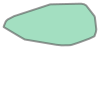

In [5]:
from shapely.geometry import MultiPolygon
hull = MultiPolygon(zones.geometry.values).convex_hull
hull

# OSMNX API

Download OSM road data on a given perimeter

In [6]:
drive = ox.graph_from_polygon(hull, network_type='drive')

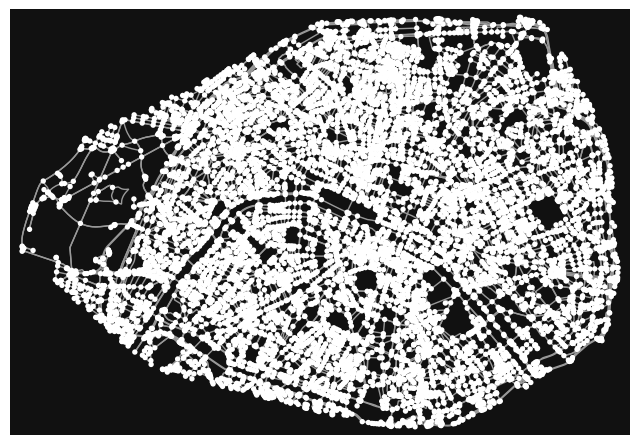

In [7]:
plot = ox.plot_graph(drive)

In [8]:
road_nodes, road_links = ox.graph_to_gdfs(drive)

In [9]:
road_nodes.head()

,y,x,street_count,highway,ref,geometry
osmid,,,,,,
125730,48.863523,2.410732,4,NaN,NaN,POINT (2.41073 48.86352)
125742,48.851852,2.401373,4,NaN,NaN,POINT (2.40137 48.85185)
125743,48.854563,2.413409,3,NaN,NaN,POINT (2.41341 48.85456)
125745,48.854524,2.414352,3,NaN,NaN,POINT (2.41435 48.85452)
125747,48.854261,2.414664,3,NaN,NaN,POINT (2.41466 48.85426)


In [10]:
road_links.head()

osmid                 name  \
u      v          key                                                
125730 268675130  0                 315818975  Rue Henri Duvernois   
       21112878   0                  31093720    Rue Louis Lumière   
       244455548  0                  85735969    Rue Louis Lumière   
       1089076182 0    [266463585, 611974677]      Rue Louis Ganne   
125742 60912980   0                   4039102      Rue de Buzenval   

                           highway maxspeed  oneway reversed   length lanes  \
u      v          key                                                         
125730 268675130  0    residential       30   False     True    8.707   NaN   
       21112878   0    residential       30   False    False  142.215     2   
       244455548  0    residential       30   False     True  105.925     2   
       1089076182 0    residential       30   False     True  128.653     2   
125742 60912980   0    residential       30    True    False  129.019   NaN   

                                                                geometry  \
u      v          key                                                      
125730 268675130  0      LINESTRING (2.41073 48.86352, 2.41083 48.86348)   
       21112878   0    LINESTRING (2.41073 48.86352, 2.41046 48.86425...   
       244455548  0    LINESTRING (2.41073 48.86352, 2.41077 48.86337...   
       1089076182 0    LINESTRING (2.41073 48.86352, 2.41061 48.86351...   
125742 60912980   0    LINESTRING (2.40137 48.85185, 2.40133 48.85192...   

                      junction width bridge tunnel  ref access  
u      v          key                                           
125730 268675130  0        NaN   NaN    NaN    NaN  NaN    NaN  
       21112878   0        NaN   NaN    NaN    NaN  NaN    NaN  
       244455548  0        NaN   NaN    NaN    NaN  NaN    NaN  
       1089076182 0        NaN   NaN    NaN    NaN  NaN    NaN  
125742 60912980   0        NaN   NaN    NaN    NaN  NaN    NaN

# Clean OSM data

In [11]:
from syspy.spatial.graph.graphbuilder import OsmnxCleaner

In [17]:
oc = OsmnxCleaner(
    road_links.reset_index(), 
    road_nodes, 
    a='u', 
    b='v'
)

In [21]:
oc.add_reversed_links(
    direction_column='oneway', 
    reverse_value=False
)
oc.clean_geometries()
oc.fix_nodeset_consistency()

c:\Users\rgoix\Documents\dev\formation\syspy_examples\syspy\../../quetzal\syspy\spatial\graph\graphbuilder.py:259: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  self.nodes = self.nodes.loc[set(self.links['a']).union(self.links['b'])]


In [22]:
# drop duplicated links
oc.links['osmid_tuple'] = oc.links['osmid'].apply(lambda x: tuple(x) if isinstance(x, list) else tuple([x]))
oc.links = oc.links.drop_duplicates(subset=['a', 'b', 'osmid_tuple'])

In [23]:
oc.links[['a', 'b', 'length', 'geometry']].to_file(ipath + r'osm/road_links.geojson', driver='GeoJSON')
oc.nodes[['geometry']].to_file(
    ipath + r'osm/road_nodes.geojson', driver='GeoJSON'
)

# Match

Project a given route / list of links on the road network

In [24]:
# read route/links
routes = gpd.read_file(ipath + r'osm/route.geojson')

from quetzal.io import importer
links, nodes = importer.links_and_nodes(routes.geometry.values[0])
links = links.loc[links['direction_id']==0]
links, nodes = gpd.GeoDataFrame(links), gpd.GeoDataFrame(nodes)

<AxesSubplot: >

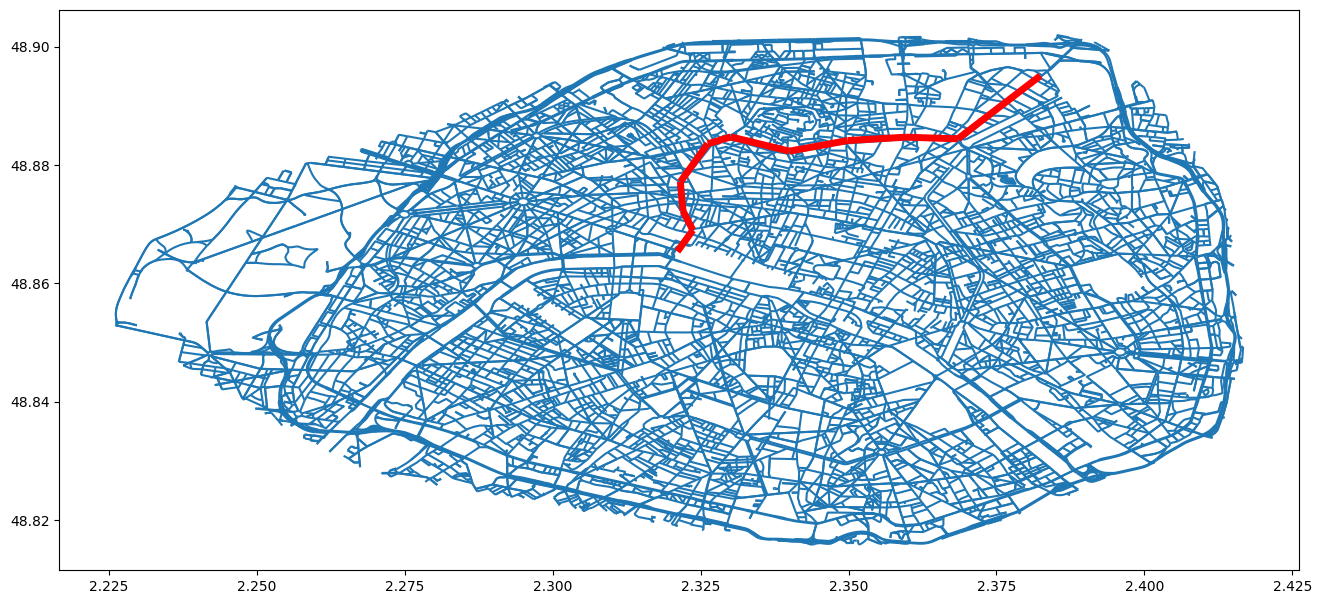

In [25]:
ax = road_links.plot()
links.plot(
    ax=ax, color='r', linewidth=5
)

In [26]:
from quetzal.engine.add_network import NetworkCaster
# init
links['trip_id'] = '1' # required keyword
nc = NetworkCaster(nodes, links, oc.nodes, oc.links)


In [27]:
# build the projected links
nc.build(
    penalty_factor=2,
    geometry=True,
)

c:\Users\rgoix\AppData\Local\Continuum\anaconda3\envs\quetzal_latest\lib\site-packages\pandas\core\dtypes\cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
1: 100%|██████████| 1/1 [00:00<00:00, 90.65it/s]
c:\Users\rgoix\AppData\Local\Continuum\anaconda3\envs\quetzal_latest\lib\site-packages\pandas\core\dtypes\cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
c:\Users\rgoix\AppData\Local\Continuum\anaconda3\envs\quetzal_latest\lib\site-packages\pandas\core\dtypes\cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_f

In [28]:
nc.links.head()

,a,b,link_sequence,direction_id,trip_id,road_a,road_b,road_node_list,road_link_list,road_length,geometry
0,0,1,0,0,1,202118936,2401441954,"[202118936, 367950.0, 94188138.0, 884214101.0,...","[11314, 331, 7866, 16084, 11256, 16083, 3367, ...",1554.855,"LINESTRING (2.38233 48.89479, 2.38227 48.89474..."
1,1,2,1,0,1,2401441954,2864793308,"[2401441954, 432814410.0, 122628005.0, 9418576...","[17425, 15134, 9206, 7845, 16281, 17695]",676.275,"LINESTRING (2.36859 48.88417, 2.36845 48.88420..."
2,2,3,2,0,1,2864793308,408479981,"[2864793308, 8122172369.0, 94249865.0, 6504194...","[17696, 19203, 8271, 15660, 15533, 16488, 1311...",758.881,"LINESTRING (2.35938 48.88453, 2.35921 48.88453..."
3,3,4,3,0,1,408479981,583011683,"[408479981, 361112.0, 94233621.0, 367932.0, 19...","[14999, 166, 8173, 321, 1809, 8176, 15001, 8106]",776.341,"LINESTRING (2.34948 48.88413, 2.34948 48.88397..."
4,4,5,4,0,1,583011683,272677541,"[583011683, 94177951.0, 256024828.0, 94226653....","[15545, 7797, 12761, 8108, 8197, 318, 15102, 1...",791.441,"LINESTRING (2.33964 48.88217, 2.33950 48.88219..."


C:\Users\rgoix\AppData\Local\Temp\ipykernel_1264\3231222781.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffer = routes.buffer(0.01).values[0]


<AxesSubplot: >

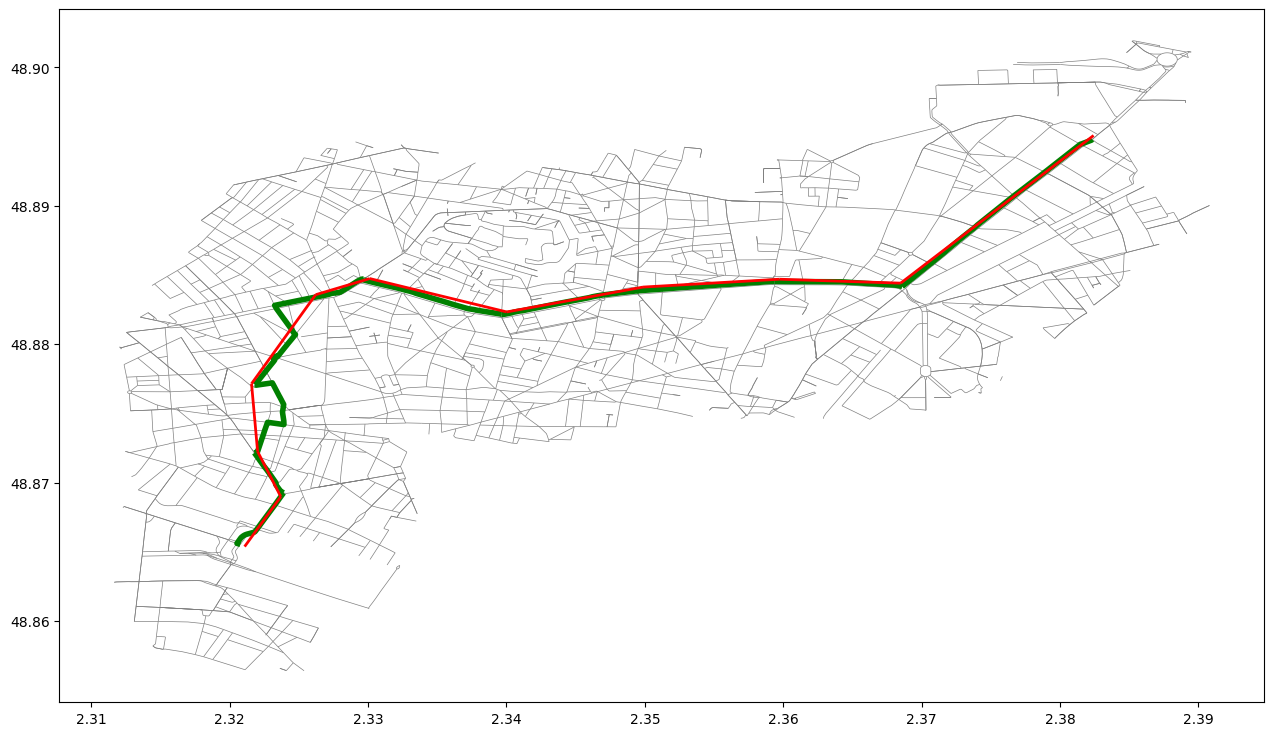

In [29]:
buffer = routes.buffer(0.01).values[0]
ax = oc.links.loc[oc.links.within(buffer)].plot(linewidth=0.5, color='grey')
ax = nc.links.plot(color='g', ax=ax, linewidth=4)
links.plot(ax=ax, color='r', linewidth=2)